# Serbian Legal Named Entity Recognition (NER) Pipeline - Refactored

This notebook demonstrates the refactored Serbian Legal NER pipeline using shared modules.

## Entity Types
- **COURT**: Court institutions
- **DECISION_DATE**: Dates of legal decisions
- **CASE_NUMBER**: Case identifiers
- **CRIMINAL_ACT**: Criminal acts/charges
- **PROSECUTOR**: Prosecutor entities
- **DEFENDANT**: Defendant entities
- **JUDGE**: Judge names
- **REGISTRAR**: Court registrar
- **SANCTION**: Sanctions/penalties
- **SANCTION_TYPE**: Type of sanction
- **SANCTION_VALUE**: Value/duration of sanction
- **PROVISION**: Legal provisions
- **PROCEDURE_COSTS**: Legal procedure costs

In [1]:
# Mount Google Drive (for Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    USE_COLAB = True
except ImportError:
    USE_COLAB = False
    print("Running locally")

Mounted at /content/drive


## 1. Environment Setup and Dependencies

In [2]:
# Install required packages
!pip install transformers torch datasets tokenizers scikit-learn seqeval pandas numpy matplotlib seaborn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=0779d8a8abd2cdbc8b41ce9ba66f82a1d64330ac26760ff5f9a2a6352accd490
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


In [3]:
# Import shared modules
import sys
import os

# Add the shared modules to path
if USE_COLAB:
    sys.path.append('/content/drive/MyDrive/NER_Master/ner/')
else:
    sys.path.append('../shared')

import importlib
import shared
import shared.model_utils
import shared.data_processing
import shared.dataset
import shared.evaluation
import shared.config
importlib.reload(shared.config)
importlib.reload(shared.data_processing)
importlib.reload(shared.dataset)
importlib.reload(shared.model_utils)
importlib.reload(shared.evaluation)
importlib.reload(shared)

# Import from shared modules
from shared import (
    # Configuration
    ENTITY_TYPES, BIO_LABELS, DEFAULT_TRAINING_ARGS,
    get_default_model_config, get_paths, setup_environment,

    # Data processing
    LabelStudioToBIOConverter, load_labelstudio_data,
    analyze_labelstudio_data, validate_bio_examples,

    # Dataset
    NERDataset, split_dataset, tokenize_and_align_labels_with_sliding_window,
    print_sequence_analysis, create_huggingface_datasets,

    # Model utilities
    load_model_and_tokenizer, create_training_arguments, create_trainer,
    detailed_evaluation, save_model_info, setup_device_and_seed,

    # Evaluation
    generate_evaluation_report, plot_training_history, plot_entity_distribution
)

# Standard imports
import warnings
warnings.filterwarnings('ignore')

from transformers import DataCollatorForTokenClassification

# Setup device and random seed
device = setup_device_and_seed(42)

🔧 Setup complete:
  PyTorch version: 2.8.0+cu126
  CUDA available: True
  CUDA device: Tesla T4
  Device: cuda
  Random seed: 42


## 2. Configuration and Environment Setup

In [4]:
# Setup environment and paths
env_setup = setup_environment(use_local=not USE_COLAB, create_dirs=True)
paths = env_setup['paths']

# Model configuration
MODEL_NAME = "classla/bcms-bertic"
model_config = get_default_model_config()

# Output directory
OUTPUT_DIR = f"{paths['models_dir']}/bertic_base"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"🔧 Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Entity types: {len(ENTITY_TYPES)}")
print(f"  BIO labels: {len(BIO_LABELS)}")

🔧 Environment setup (cloud):
  ✅ labelstudio_json: /content/drive/MyDrive/NER_Master/annotations.json
  ✅ judgments_dir: /content/drive/MyDrive/NER_Master/judgments
  ✅ labelstudio_files_dir: /content/drive/MyDrive/NER_Master/judgments
  ✅ mlm_data_dir: /content/drive/MyDrive/NER_Master/dapt-mlm
  ✅ models_dir: /content/drive/MyDrive/NER_Master/models
  ✅ logs_dir: /content/drive/MyDrive/NER_Master/logs
  ✅ results_dir: /content/drive/MyDrive/NER_Master/results
🔧 Configuration:
  Model: classla/bcms-bertic
  Output directory: /content/drive/MyDrive/NER_Master/models/bertic_base
  Entity types: 16
  BIO labels: 33


## 3. Data Loading and Analysis

In [5]:
# Load LabelStudio data
labelstudio_data = load_labelstudio_data(paths['labelstudio_json'])

# Analyze the data
if labelstudio_data:
    analysis = analyze_labelstudio_data(labelstudio_data)
else:
    print("❌ No data loaded. Please check your paths.")
    exit()

✅ Loaded 225 annotated documents from /content/drive/MyDrive/NER_Master/annotations.json
📊 Analysis Results:
Total documents: 225
Total annotations: 225
Unique entity types: 14

Entity distribution:
  DEFENDANT: 1240
  PROVISION_MATERIAL: 1177
  CRIMINAL_ACT: 792
  PROVISION_PROCEDURAL: 686
  REGISTRAR: 460
  COURT: 458
  JUDGE: 451
  PROSECUTOR: 395
  DECISION_DATE: 359
  SANCTION_TYPE: 248
  SANCTION_VALUE: 241
  VERDICT: 238
  PROCEDURE_COSTS: 231
  CASE_NUMBER: 225


## 4. Data Preprocessing and BIO Conversion

In [6]:
# Convert LabelStudio data to BIO format
converter = LabelStudioToBIOConverter(
    judgments_dir=paths['judgments_dir'],
    labelstudio_files_dir=paths.get('labelstudio_files_dir')
)

bio_examples = converter.convert_to_bio(labelstudio_data)
print(f"✅ Converted {len(bio_examples)} examples to BIO format")

# Validate BIO examples
valid_examples, stats = validate_bio_examples(bio_examples)
print(f"📊 Validation complete: {stats['valid_examples']} valid examples")

✅ Converted 225 examples to BIO format
📊 BIO Validation Results:
Total examples: 225
Valid examples: 225
Invalid examples: 0
Empty examples: 0
📊 Validation complete: 225 valid examples


## 5. Dataset Preparation

In [7]:
# Create NER dataset
ner_dataset = NERDataset(valid_examples)
prepared_examples = ner_dataset.prepare_for_training()

print(f"📊 Dataset statistics:")
print(f"  Number of unique labels: {ner_dataset.get_num_labels()}")
print(f"  Prepared examples: {len(prepared_examples)}")

# Get label statistics
label_stats = ner_dataset.get_label_statistics()
print(f"  Total tokens: {label_stats['total_tokens']}")
print(f"  Entity types found: {len(label_stats['entity_counts'])}")

📊 Dataset statistics:
  Number of unique labels: 29
  Prepared examples: 225
  Total tokens: 232475
  Entity types found: 14


## 6. Data Splitting and Tokenization

In [8]:
# Split dataset
train_examples, val_examples, test_examples = split_dataset(
    prepared_examples, test_size=0.2, val_size=0.1, random_state=42
)

# Load model and tokenizer
model, tokenizer = load_model_and_tokenizer(
    MODEL_NAME,
    ner_dataset.get_num_labels(),
    ner_dataset.id_to_label,
    ner_dataset.label_to_id
)

# Analyze sequence lengths
print("\n📏 Sequence length analysis:")
print("\nTraining set:")
print_sequence_analysis(train_examples, tokenizer)
print("\nValidation set:")
print_sequence_analysis(val_examples, tokenizer)

📊 Dataset split:
Training examples: 157
Validation examples: 23
Test examples: 45
🔄 Loading model and tokenizer...
📥 Model: classla/bcms-bertic
🏷️  Number of labels: 29


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

✅ Loaded tokenizer (vocab size: 32000)


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda

📏 Sequence length analysis:

Training set:
📏 Sequence Length Analysis:
  Total sequences: 157
  Mean length: 1649.1
  Median length: 1024.0
  Std deviation: 1267.4
  Min length: 581
  Max length: 7913
  95th percentile: 4134.6
  99th percentile: 4959.8
  Sequences > 512 tokens: 157 (100.0%)
  Sequences > 256 tokens: 157 (100.0%)

Validation set:
📏 Sequence Length Analysis:
  Total sequences: 23
  Mean length: 1518.8
  Median length: 1029.0
  Std deviation: 1056.6
  Min length: 604
  Max length: 4078
  95th percentile: 3909.2
  99th percentile: 4044.3
  Sequences > 512 tokens: 23 (100.0%)
  Sequences > 256 tokens: 23 (100.0%)


In [9]:
# Tokenize datasets
print("🔤 Tokenizing datasets...")

train_tokenized = tokenize_and_align_labels_with_sliding_window(
    train_examples, tokenizer, ner_dataset.label_to_id,
    max_length=model_config['max_length'], stride=model_config['stride']
)

val_tokenized = tokenize_and_align_labels_with_sliding_window(
    val_examples, tokenizer, ner_dataset.label_to_id,
    max_length=model_config['max_length'], stride=model_config['stride']
)

test_tokenized = tokenize_and_align_labels_with_sliding_window(
    test_examples, tokenizer, ner_dataset.label_to_id,
    max_length=model_config['max_length'], stride=model_config['stride']
)

# Create HuggingFace datasets
train_dataset, val_dataset, test_dataset = create_huggingface_datasets(
    train_tokenized, val_tokenized, test_tokenized
)

# Data collator
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True,
    return_tensors="pt"
)

print("✅ Tokenization complete")

🔤 Tokenizing datasets...
📦 Created HuggingFace datasets:
  Training: 1630 examples
  Validation: 215 examples
  Test: 500 examples
✅ Tokenization complete


## 7. Model Training

In [10]:
# Create training arguments
training_args = create_training_arguments(
    output_dir=OUTPUT_DIR,
    num_epochs=model_config['num_epochs'],
    batch_size=model_config['batch_size'],
    learning_rate=model_config['learning_rate'],
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=50,
    eval_steps=100,
    save_steps=500,
    early_stopping_patience=3
)

# Create trainer
trainer = create_trainer(
    model=model,
    training_args=training_args,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    id_to_label=ner_dataset.id_to_label,
    early_stopping_patience=3
)

print("🏋️  Starting training...")
trainer.train()

print("💾 Saving model...")
trainer.save_model()
tokenizer.save_pretrained(OUTPUT_DIR)

# Save model info
save_model_info(
    output_dir=OUTPUT_DIR,
    model_name=MODEL_NAME,
    num_labels=ner_dataset.get_num_labels(),
    label_to_id=ner_dataset.label_to_id,
    id_to_label=ner_dataset.id_to_label,
    model_type="standard",
    entity_types=ENTITY_TYPES
)

print("✅ Training completed!")

⚙️  Training configuration:
  Epochs: 8
  Batch size: 4
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
🏋️  Created trainer with early stopping (patience: 3)
📊 Training dataset size: 1630
📊 Validation dataset size: 215
🏋️  Starting training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pericapero1 (pericapero1-faculty-of-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,2.243500,0.810997,0.000000,0.000000,0.000000,0.915233
200,0.403700,0.268091,0.309494,0.158460,0.209603,0.940902
300,0.205500,0.188003,0.551896,0.349116,0.427688,0.962887
400,0.161900,0.131235,0.609339,0.494318,0.545835,0.974303
500,0.095300,0.105385,0.656801,0.728535,0.690811,0.979849
600,0.087400,0.086153,0.652555,0.797980,0.717978,0.982050
700,0.062700,0.076861,0.667009,0.819444,0.735411,0.982699
800,0.050100,0.069654,0.725169,0.811237,0.765793,0.985846
900,0.035500,0.067540,0.768258,0.843434,0.804093,0.986622
1000,0.037100,0.069980,0.803922,0.854167,0.828283,0.985790


💾 Saving model...
💾 Model information saved to /content/drive/MyDrive/NER_Master/models/bertic_base/model_info.json
✅ Training completed!


## 8. Model Evaluation

In [11]:
# Evaluate on test set
print("📊 Evaluating model on test set...")

test_results = detailed_evaluation(
    trainer=trainer,
    dataset=test_dataset,
    dataset_name="Test",
    id_to_label=ner_dataset.id_to_label
)

print(f"\n📈 Test Results:")
print(f"  Precision: {test_results['precision']:.4f}")
print(f"  Recall: {test_results['recall']:.4f}")
print(f"  F1-score: {test_results['f1']:.4f}")
print(f"  Accuracy: {test_results['accuracy']:.4f}")

📊 Evaluating model on test set...



📊 Test Set Results:
  Precision: 0.8153
  Recall: 0.8567
  F1-score: 0.8355
  Accuracy: 0.9849

Test Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       0.62      0.96      0.75        45
               B-COURT       0.90      0.97      0.93       122
        B-CRIMINAL_ACT       0.97      0.95      0.96       519
       B-DECISION_DATE       0.92      0.96      0.94       114
           B-DEFENDANT       0.69      0.71      0.70       811
               B-JUDGE       0.94      0.94      0.94       107
     B-PROCEDURE_COSTS       1.00      1.00      1.00       141
          B-PROSECUTOR       0.54      0.55      0.54       241
  B-PROVISION_MATERIAL       0.95      0.96      0.96       819
B-PROVISION_PROCEDURAL       0.93      0.96      0.94       381
           B-REGISTRAR       0.87      0.97      0.92       113
       B-SANCTION_TYPE       0.89      0.94      0.92       197
      B-SANCTION_VALUE     

In [12]:
# Generate comprehensive evaluation report
evaluation_report = generate_evaluation_report(
    true_labels=test_results['true_labels'],
    predictions=test_results['true_predictions'],
    dataset_name="Test",
    focus_entities=["COURT", "JUDGE", "DEFENDANT", "CRIMINAL_ACT"]
)


🔍 COMPREHENSIVE EVALUATION REPORT - TEST

📊 Test Confusion Matrix Analysis

🔍 Most Confused Label Pairs:
  I-PROVISION_MATERIAL → I-PROVISION_PROCEDURAL: 228
  B-DEFENDANT → O: 226
  I-DEFENDANT → O: 191
  O → B-DEFENDANT: 180
  I-PROVISION_PROCEDURAL → I-PROVISION_MATERIAL: 170
  O → I-DEFENDANT: 142
  O → B-PROSECUTOR: 107
  O → I-PROVISION_PROCEDURAL: 100
  O → I-PROVISION_MATERIAL: 95
  B-PROSECUTOR → B-DEFENDANT: 74

🔍 DETAILED MISCLASSIFICATION ANALYSIS

🔍 ANALYZING: COURT

  📋 B-COURT:
    ✅ Correct predictions: 118/122 (96.72%)
    ❌ Misclassified as:
       → O: 4 times (3.28%)

  📋 I-COURT:
    ✅ Correct predictions: 412/425 (96.94%)
    ❌ Misclassified as:
       → O: 13 times (3.06%)
📊 Total true instances: 547

🔍 ANALYZING: JUDGE

  📋 B-JUDGE:
    ✅ Correct predictions: 101/107 (94.39%)
    ❌ Misclassified as:
       → B-REGISTRAR: 5 times (4.67%)
       → I-JUDGE: 1 times (0.93%)

  📋 I-JUDGE:
    ✅ Correct predictions: 106/110 (96.36%)
    ❌ Misclassified as:
       → I

## 9. Training History Visualization

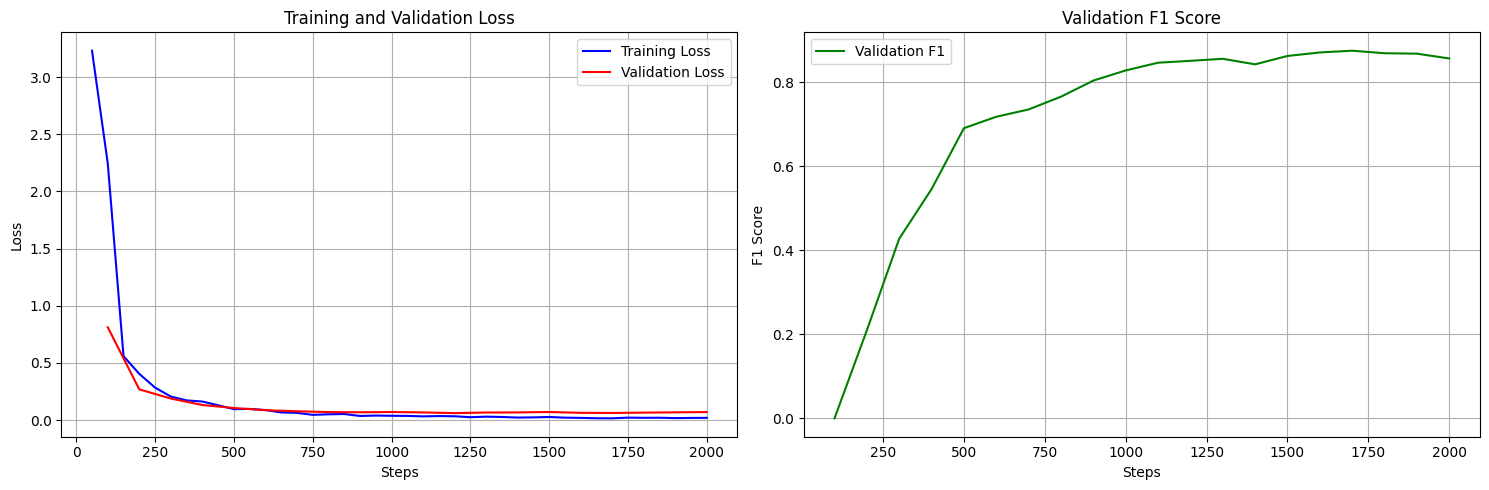

📈 Training history plotted successfully!


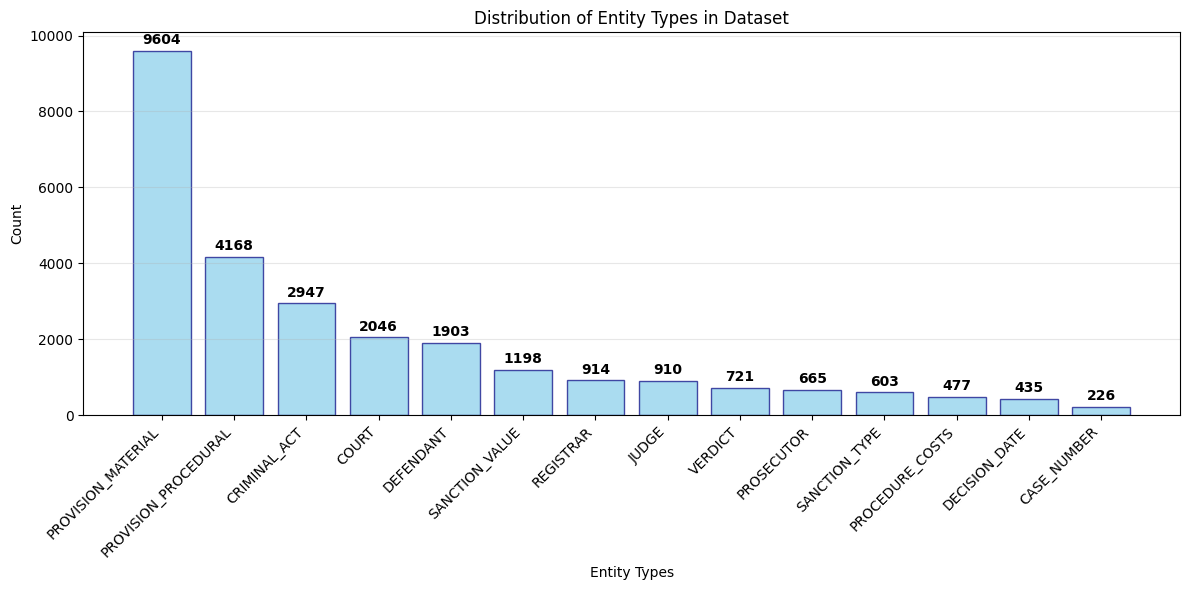

📊 Entity distribution plotted successfully!


In [13]:
# Plot training history
plot_training_history(trainer)

# Plot entity distribution
label_stats = ner_dataset.get_label_statistics()
plot_entity_distribution(label_stats['entity_counts'])

## 11. Summary and Results

In [14]:
print("\n🎯 FINAL SUMMARY")
print("=" * 50)
print(f"Model: {MODEL_NAME}")
print(f"Training examples: {len(train_examples)}")
print(f"Validation examples: {len(val_examples)}")
print(f"Test examples: {len(test_examples)}")
print(f"Entity types: {len(ENTITY_TYPES)}")
print(f"BIO labels: {len(BIO_LABELS)}")
print(f"\nTest Performance:")
print(f"  Precision: {test_results['precision']:.4f}")
print(f"  Recall: {test_results['recall']:.4f}")
print(f"  F1-score: {test_results['f1']:.4f}")
print(f"  Accuracy: {test_results['accuracy']:.4f}")
print(f"\nModel saved to: {OUTPUT_DIR}")
print("\n✅ Pipeline completed successfully!")


🎯 FINAL SUMMARY
Model: classla/bcms-bertic
Training examples: 157
Validation examples: 23
Test examples: 45
Entity types: 16
BIO labels: 33

Test Performance:
  Precision: 0.8153
  Recall: 0.8567
  F1-score: 0.8355
  Accuracy: 0.9849

Model saved to: /content/drive/MyDrive/NER_Master/models/bertic_base

✅ Pipeline completed successfully!
